In [1]:
! pip install snntorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
#! pip install lightly

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
#from lightly.loss import NTXentLoss


In [3]:
#from lightly.data import LightlyDataset, SimCLRCollateFunction, collate

In [4]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'


dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
#collate_fn = SimCLRCollateFunction(input_size=batch_size, vf_prob=0.5, rr_prob=0.5)


In [6]:
# Define a transform
transform = transforms.Compose([
            #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            #transforms.RandomRotation(degrees=(0, 180)),
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])



In [7]:
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform )

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 78092144.80it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 61272480.44it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28668095.66it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10525154.02it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [8]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True )

test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)



Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


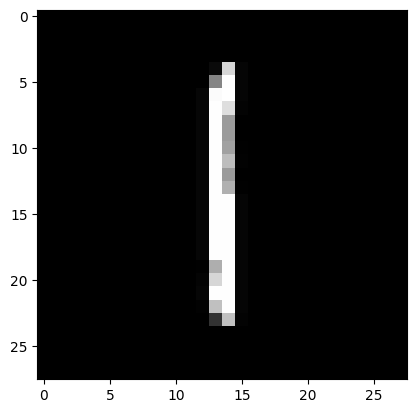

Label: 1


In [9]:
# Display image and label.
train_features, train_labels  = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

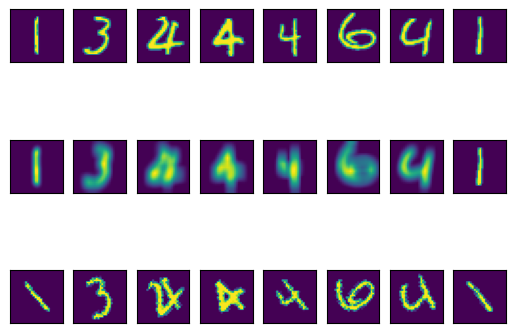

In [10]:
n = 8
fig, ax = plt.subplots(3,n,)
g_transform = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
r_transform = transforms.RandomRotation(degrees=(30, 45))
for i, img in enumerate(train_features[:n]):
  # plt.imshow(i.squeeze())
  ax[0][i].imshow(img.squeeze())
  ax[1][i].imshow(g_transform(img).squeeze())
  ax[2][i].imshow(r_transform(img).squeeze())
  for j in range(3):
    ax[j][i].get_xaxis().set_visible(False)
    ax[j][i].get_yaxis().set_visible(False)


In [11]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 64

# Temporal Dynamics
num_steps = 5
beta = 0.9

In [12]:
def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print("\n")

In [13]:
 #Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [14]:
! pip install pytorch-metric-learning


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 2.6 MB/s eta 0:00:00


In [15]:
! pip install pytorch-metric-learning --pre


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from pytorch_metric_learning.losses import NTXentLoss
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
from pytorch_metric_learning.losses import SelfSupervisedLoss


In [17]:
loss_func_self = SelfSupervisedLoss(losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    reducer = ThresholdReducer(high=0.3), 
                                    embedding_regularizer = LpRegularizer()))
loss_func_NTX = NTXentLoss(losses.contrastive)

loss_func_triplet = losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    reducer = ThresholdReducer(high=0.3), 
                                    embedding_regularizer = LpRegularizer())

In [18]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [19]:
data_r=r_transform(data)
data_g=g_transform(data)

spk_rec_r, mem_rec_r = net(data_r.view(batch_size, -1))
spk_rec_g, mem_rec_g = net(data_g.view(batch_size, -1))

In [20]:
mse_loss = nn.MSELoss()
cosine_loss = nn.CosineSimilarity(dim=0)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


In [21]:
num_epochs = 5
loss_hist = []
test_loss_hist = []
counter = 0


# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()

        data_r=r_transform(data)
        data_g=g_transform(data)

        spk_rec_r, mem_rec_r = net(data_r.view(batch_size, -1))
        spk_rec_g, mem_rec_g = net(data_g.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(num_steps):
            #print(mem_rec_r[step])
            loss_val += loss_func_self(mem_rec_r[step], mem_rec_g[step])

        # Gradient calculation + weight updat
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            '''# Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
        # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1'''
            

0
1
2
3
4


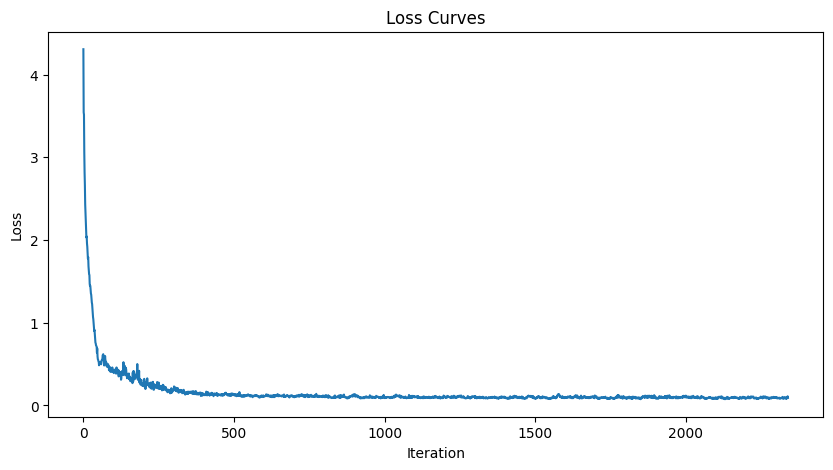

In [22]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
#.plot(test_loss_hist)
plt.title("Loss Curves")
#plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

In [ ]:
#KNN

In [23]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

In [24]:
n_neighbors=3

num_examples=4

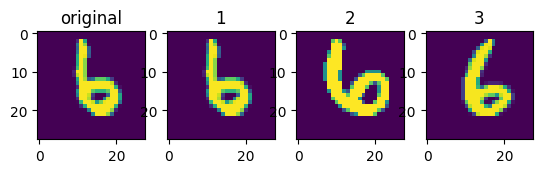

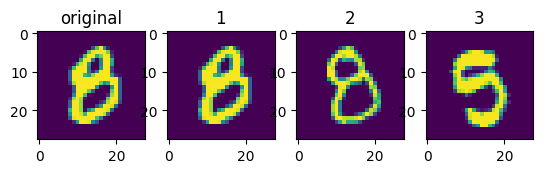

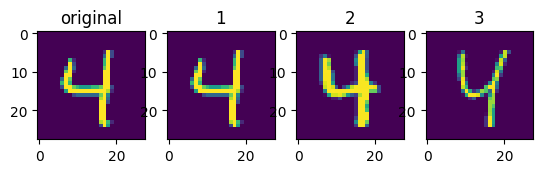

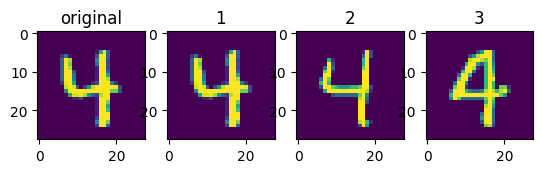

In [25]:

nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(test_mem.sum(dim=0))

distances, indices = nbrs.kneighbors(test_mem.sum(dim=0))

samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors+1)
    ax[0].imshow(test_data.squeeze()[samples_idx[i]])
    ax[0].set_title('original')
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j+1].imshow(test_data.squeeze()[k])
      ax[j+1].set_title(j+1)
    

In [26]:
#classifier

In [27]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [28]:
 #Define Network

class Classifier(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        # use the pretrained ResNet backbone
        self.backbone = backbone

        # freeze the backbone
        for param in backbone.parameters():
           param.requires_grad = False

        # create a linear layer for our downstream classification model
        self.fc = nn.Linear(64, 10)


    def forward(self, x):
        spk,mem = self.backbone(x)
        y_hat = self.fc(mem)
        return y_hat

# Load the network onto CUDA if available
classifier = Classifier(net).to(device)

In [29]:
classifier

Classifier(
  (backbone): Net(
    (fc1): Linear(in_features=784, out_features=1000, bias=True)
    (lif1): Leaky()
    (fc2): Linear(in_features=1000, out_features=64, bias=True)
    (lif2): Leaky()
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [30]:
mse_loss = nn.MSELoss()
cosine_loss = torch.nn.CosineSimilarity(dim=0)
cross_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.1, betas=(0.9, 0.999))


In [31]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        classifier.train()
        mem_rec = classifier(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += cross_loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            classifier.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_mem = classifier(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += mse_loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            '''# Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1'''

0
1
2
3
4
5
6
7
8
9


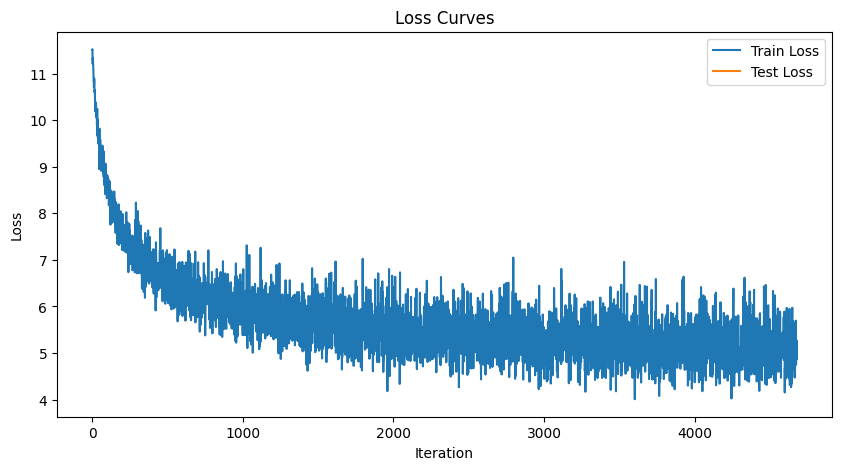

In [32]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [33]:
test_pred=test_mem.sum(dim=0).max(1)[1]

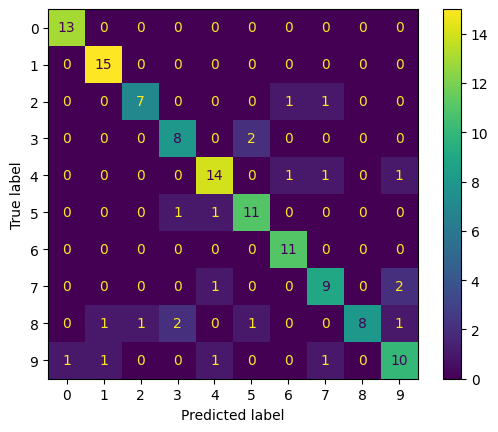

In [34]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_targets, test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()


In [35]:
acc = np.mean((test_targets == test_pred).detach().cpu().numpy())
print(acc)

0.828125
